In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   data


In [0]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data")
print(os.getcwd())

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [0]:
# set your path to datasets
train_dir = os.path.join('./datasets', 'Dogs_vs_Cats', 'data_small', 'train')
val_dir = os.path.join('./datasets', 'Dogs_vs_Cats', 'data_small', 'validation')
test_dir = os.path.join('./datasets', 'Dogs_vs_Cats', 'data_small', 'test')

In [0]:
BATCH_SIZE = 96

In [6]:
dirs = {'train':train_dir, 'val':val_dir, 'test':test_dir}

data_transforms = {
    'train' : transforms.Compose([
                 transforms.RandomResizedCrop(224),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
}


image_datasets = {x: datasets.ImageFolder(dirs[x], data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                                               shuffle=True, num_workers=4) for x in  ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


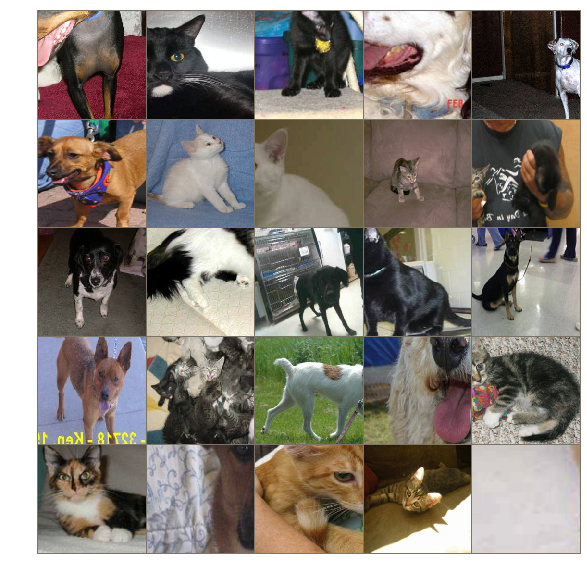

[['dogs' 'cats' 'cats' 'dogs' 'dogs']
 ['dogs' 'cats' 'cats' 'cats' 'cats']
 ['dogs' 'cats' 'dogs' 'cats' 'dogs']
 ['dogs' 'cats' 'dogs' 'dogs' 'cats']
 ['cats' 'dogs' 'cats' 'cats' 'dogs']]


In [7]:
import math

def imshow(img, figsize=(5,5), title=None):
    plt.figure(figsize=figsize)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis('off')
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()


inputs, labels = next(iter(dataloaders['train']))

n_show = 25
nrow = int(math.sqrt(n_show))

inputs = inputs[:n_show]
labels = labels[:n_show]

grid = torchvision.utils.make_grid(inputs, nrow=nrow)
imshow(grid, figsize=(10,10))

class_list = [class_names[labels[j]] for j in range(n_show)]
class_list = np.array(class_list)
print(class_list.reshape(nrow, nrow))

In [0]:
import copy
import time

class Trainer:
    
    def __init__(self, model, device, optimizer, criterion, train_loader, val_loader=None,
                          scheduler=None, history=None, prev_epochs=0):

        self.print_state = True
        
        self.done_epochs = prev_epochs # 0-
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.scheduler = scheduler
        
        self.best_val_acc = 0.0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        
        if history:
            self.history = history
        else:
            self.history = {'epoch':[], 'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
        
        self.train_loader = train_loader
        self.train_data_num = len(self.train_loader.dataset)
        self.train_sptes_per_epoch = len(self.train_loader)
        
        self.val_loader = val_loader
        if self.val_loader:
            self.val_data_num = len(self.val_loader.dataset)
            self.val_sptes_per_epoch = len(self.val_loader)
        else:
            self.val_data_num = 0
            self.val_sptes_per_epoch = 0

        self.model.to(self.device)
        
        
    def set_print_state(self, state=True):
        self.print_state = state
        
        
    def train_loop(self, epochs):
        total_epochs = self.done_epochs + epochs

        #------------------------------------------------------------------------
        # pre print
        #------------------------------------------------------------------------        
        if self.print_state:
            print("Device :  ", self.device)
            print("Train on {} samples, validate on {} samples".format(self.train_data_num,
                                                                                                                 self.val_data_num))
            for i in range(self.done_epochs):
                done_history_idx = i
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))

        #------------------------------------------------------------------------
        # training loop
        #------------------------------------------------------------------------
        for _ in range(epochs):
            start_time = time.time()
            self.history['epoch'].append(self.done_epochs+1) # 1-
            self.train_one_epoch()
            if self.val_loader:
                self.val_one_epoch()
            end_time = time.time()
            self.done_epochs += 1

            #------------------------------------------------------------------------
            # post print
            #------------------------------------------------------------------------
            if self.print_state:
                elapsed_time = end_time-start_time
                done_history_idx = self.done_epochs-1
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))


    def train_one_epoch(self):
        self.model.train()
        running_loss = 0
        correct = 0

        for batch_idx, (data, labels) in enumerate(self.train_loader):

            data, labels = data.to(self.device), labels.to(self.device)
           
            self.optimizer.zero_grad()
            outputs = self.model(data)

            loss = self.criterion(outputs, labels)
            loss.backward()

            self.optimizer.step()

            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            running_loss += loss.item()

        train_acc = correct / self.train_data_num
        train_loss = running_loss / self.train_sptes_per_epoch

        self.history['train_acc'].append(train_acc)
        self.history['train_loss'].append(train_loss)
            
        
    def val_one_epoch(self):
        self.model.eval()
        runnning_loss = 0
        correct = 0

        with torch.no_grad():
            for data, labels in self.val_loader:

                data, labels = data.to(self.device), labels.to(self.device)

                output = self.model(data)

                pred = output.argmax(dim=1) 
                correct +=  (pred == labels).sum().item()
                runnning_loss += self.criterion(output, labels).item()

        val_acc = correct / self.val_data_num
        val_loss = runnning_loss /self.val_sptes_per_epoch
        
        if self.scheduler:
            self.scheduler.step(val_loss)

        self.history['val_acc'].append(val_acc)
        self.history['val_loss'].append(val_loss)
        
        if self.best_val_acc < val_acc:
            self.best_val_acc = val_acc
            self.best_model_wts = copy.deepcopy(model.state_dict())
            
    
    def save_best_model(self, path):
        torch.save(self.best_model_wts, path)
        
    def save_checkpoint(self, path):
        ckpt = {
            'model_satate_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict(),
            'history':self.history
        }
        torch.save(ckpt, path)

In [9]:
model = models.resnet18(pretrained=True)
from torchsummary import summary
summary(model,  input_size=(3, 224, 224),   device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
from torch.optim import lr_scheduler

fc_in_features = model.fc.in_features
model.fc= nn.Linear(fc_in_features,  2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                                                                            patience=10,  verbose=True) 

In [0]:
trainer = Trainer(model, device, optimizer, criterion,
                             dataloaders['train'], dataloaders['val'],
                             scheduler=exp_lr_scheduler)

In [12]:
trainer.train_loop(10)

Device :   cuda:0
Train on 2000 samples, validate on 1000 samples
Epoch:1/10 train_acc:0.7970% train_loss:0.4503 val_acc:0.9680% val_loss:0.1402 time:29.453
Epoch:2/10 train_acc:0.9370% train_loss:0.1962 val_acc:0.9750% val_loss:0.0852 time:28.978
Epoch:3/10 train_acc:0.9410% train_loss:0.1602 val_acc:0.9810% val_loss:0.0701 time:28.663
Epoch:4/10 train_acc:0.9395% train_loss:0.1480 val_acc:0.9790% val_loss:0.0588 time:29.058
Epoch:5/10 train_acc:0.9415% train_loss:0.1386 val_acc:0.9830% val_loss:0.0508 time:29.360
Epoch:6/10 train_acc:0.9525% train_loss:0.1236 val_acc:0.9840% val_loss:0.0506 time:29.228
Epoch:7/10 train_acc:0.9545% train_loss:0.1150 val_acc:0.9850% val_loss:0.0478 time:29.402
Epoch:8/10 train_acc:0.9600% train_loss:0.1087 val_acc:0.9820% val_loss:0.0440 time:29.229
Epoch:9/10 train_acc:0.9545% train_loss:0.1105 val_acc:0.9840% val_loss:0.0405 time:28.853
Epoch:10/10 train_acc:0.9610% train_loss:0.1018 val_acc:0.9850% val_loss:0.0395 time:28.871


In [13]:
trainer.best_val_acc

0.985

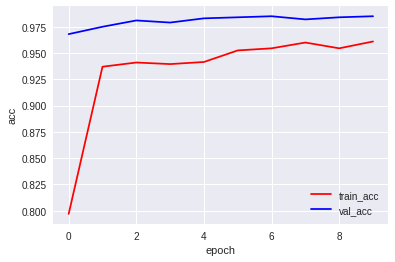

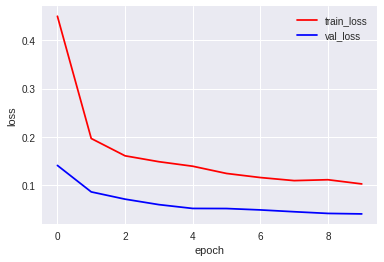

In [14]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    
plot_history(trainer.history)

In [15]:
def test(model, classes, device, criterion, test_loader):
    outsize = len(classes)
    class_correct = list(0. for i in range(outsize))
    class_total = list(0. for i in range(outsize))
    runnning_loss = 0
    with torch.no_grad():
        for data in test_loader:
            imgs, labels = data
            n_batch = imgs.size(0)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            runnning_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            c = (pred == labels).squeeze()
            for i in range(n_batch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(outsize):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    test_acc = int(sum(class_correct)/sum(class_total)*100)
    test_loss = runnning_loss / len(test_loader)
    print('acc  : {:2d}%'.format(test_acc))
    print('loss : {:.4f}'.format(test_loss) )



test_loader = dataloaders['val']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)
test(model, class_names, device, criterion, test_loader)

device: cuda
Accuracy of  cats : 98 %
Accuracy of  dogs : 98 %
acc  : 98%
loss : 0.0389
